<a href="https://colab.research.google.com/github/Rohit1217/Flow/blob/main/Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [59]:
Device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)
data_target=data*0.5+0.5
data=data.view(60000,784)
data=data.to(dtype=torch.float32)

data_target=data_target.view(60000,784)
trainset=TensorDataset(data,data_target)
trainloader=DataLoader(trainset,batch_size=256,shuffle=True)


In [61]:
class AffineCoupling(nn.Module):
  def __init__(self,input_layer):
    super(AffineCoupling,self).__init__()
    self.inp=input_layer//2
    self.fc1=nn.Linear(self.inp,1000).to(Device)
    self.fc2=nn.Linear(1000,1000).to(Device)
    self.fc3=nn.Linear(1000,1000).to(Device)
    self.fc4=nn.Linear(1000,1000).to(Device)
    self.fc5=nn.Linear(1000,self.inp).to(Device)
    #self.fc6=nn.Linear(1000,self.inp).to(Device)
    self.bn1=nn.BatchNorm1d(1000).to(Device)
    self.bn2=nn.BatchNorm1d(1000).to(Device)
    self.bn3=nn.BatchNorm1d(1000).to(Device)
    self.bn4=nn.BatchNorm1d(1000).to(Device)
    self.bn5=nn.BatchNorm1d(self.inp).to(Device)


  def coupling_shuffler(self,x):
    b,c=x.shape
    layer=torch.rand(b,c).to(Device)
    for i in range(c):
      if i%2==0:
        layer[:,c//2+i//2]=x[:,i]
      else:
        layer[:,i//2]=x[:,i]
    return layer

  def inverse(self,x):
    b,c=x.shape
    x0=x[:,:c//2]
    x1=x[:,c//2:]
    z=self.bn1(F.relu(self.fc1(x0)))
    z=self.bn2(F.relu(self.fc2(z)))
    z=self.bn3(F.relu(self.fc3(z)))
    z=self.bn4(F.relu(self.fc4(z)))
    z=self.bn5(F.relu(self.fc5(z)))
    x1=x1-z
    x=torch.cat((x0, x1), 1)
    layer=torch.rand(b,c).to(Device)
    for i in range(c):
      if i>=c//2:
        layer[:,2*i-c]=x[:,i]
      else:
        layer[:,i*2+1]=x[:,i]
    return layer


  def forward(self,x):
    b,c=x.shape
    x=self.coupling_shuffler(x)
    x0=x[:,:c//2]
    x1=x[:,c//2:]

    z=self.bn1(F.relu(self.fc1(x0)))
    z=self.bn2(F.relu(self.fc2(z)))
    z=self.bn3(F.relu(self.fc3(z)))
    z=self.bn4(F.relu(self.fc4(z)))
    z=self.bn5(F.relu(self.fc5(z)))

    x1=x1+z
    x=torch.cat((x0, x1), 1)
    return x

x=torch.rand(2,6)
print(x)
aff=AffineCoupling(6)
y=aff(x)
print(aff(x))
aff.inverse(y)


tensor([[0.9799, 0.1246, 0.1398, 0.7253, 0.0744, 0.9966],
        [0.6626, 0.0828, 0.5762, 0.1232, 0.3695, 0.1389]])
tensor([[ 0.1246,  0.7253,  0.9966, -0.0200,  1.1397, -0.9256],
        [ 0.0828,  0.1232,  0.1389,  1.6625, -0.4237,  1.3695]],
       device='cuda:0', grad_fn=<CatBackward0>)


tensor([[0.9799, 0.1246, 0.1398, 0.7253, 0.0744, 0.9966],
        [0.6626, 0.0828, 0.5762, 0.1232, 0.3695, 0.1389]], device='cuda:0',
       grad_fn=<CopySlices>)

In [89]:
class Flow(nn.Module):
  def __init__(self,input_layer):
    super(Flow,self).__init__()
    self.inp=input_layer
    self.ac1=AffineCoupling(input_layer)
    self.ac2=AffineCoupling(input_layer)
    self.ac3=AffineCoupling(input_layer)
    self.ac4=AffineCoupling(input_layer)
    self.w=nn.Parameter(torch.randn(input_layer)).to(Device)

  def inverse(self,x):
    #x=torch.rand(self.inp)
    x= torch.log((x/(1-x+1e-8))+1e-8)
    x=x*(torch.pow(torch.exp(self.w),-1))
    x=self.ac1.inverse(x)
    x=self.ac1.inverse(x)
    x=self.ac1.inverse(x)
    x=self.ac1.inverse(x)
    return x


  def forward(self,x):
    x=self.ac1(x)
    x=self.ac1(x)
    x=self.ac1(x)
    x=self.ac1(x)
    x=torch.exp(self.w)*x
    x=F.sigmoid(x)
    return x

x=torch.rand(2,784)
x=x.to(Device)
print(x)
flow=Flow(784)
y=flow(x)
x=flow.inverse(y)
print(y,x)


tensor([[0.1103, 0.5710, 0.4811,  ..., 0.5431, 0.8747, 0.8962],
        [0.4160, 0.3918, 0.3388,  ..., 0.4456, 0.5781, 0.1957]],
       device='cuda:0')
tensor([[0.8192, 0.5834, 0.6512,  ..., 0.5286, 0.4429, 0.1277],
        [0.5645, 0.8393, 0.6453,  ..., 0.5818, 0.5957, 0.9551]],
       device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[ 4.1103,  0.5643, -1.5182,  ...,  2.5428,  0.8747,  0.8962],
        [-3.5839,  0.3985,  2.3381,  ..., -1.5541,  0.5781,  0.1957]],
       device='cuda:0', grad_fn=<CopySlices>)


In [63]:
def loss_f(x,model):
  x= torch.log(torch.sum(x,dim=1))
  w=torch.sum(model.w)
  loss=-x-w
  loss=torch.mean(loss)
  return loss
flow=Flow(784)
x=torch.randn(2,784)
y=flow(x)
loss_f(y,flow)

tensor(-14.5055, device='cuda:0', grad_fn=<MeanBackward0>)

In [90]:
epochs=100
model=Flow(784)
optimizer=optim.Adam(model.parameters(),lr=0.001)
model=model.to(Device)

In [91]:
model.train()
for epoch in range(epochs):
  total_loss=0
  count=0
  for input,_ in trainloader:
    input=input.to(Device)
    input=model(input)
    loss=loss_f(input,model)

    total_loss+=loss.item()
    count+=1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'total_loss={total_loss},average_loss={total_loss/count}.epoch={epoch}')


total_loss=282.02182400226593,average_loss=1.2000928680947487.epoch=0
total_loss=234.69150406122208,average_loss=0.9986872513243492.epoch=1


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  #model.eval()
  x=data[:64]
  #print(x)
  x=torch.randn(64,784)
  x=x.to('cuda:0')
  #x=flow(x)
  x = x.view(8, 8, 28, 28)
  x = x.to('cpu')
  image_np = x.detach().numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()

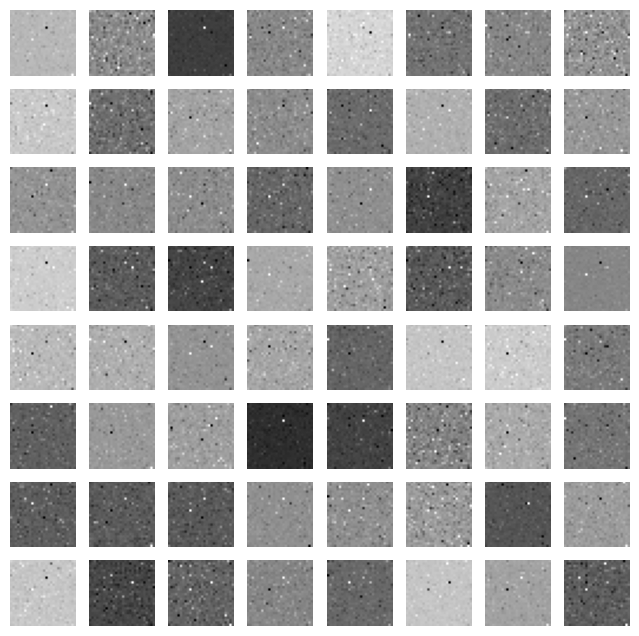

In [92]:
with torch.no_grad():
  #model.eval()
  x=data[:64]
  #print(x)
  x=torch.rand(64,784)
  x=x.to('cuda:0')
  x=flow.inverse(x)
  x = x.view(8,8, 28, 28)
  x = x.to('cpu')
  image_np = x.detach().numpy()

  # Create a figure and a set of subplots arranged in an 8x8 grid
  fig, axes = plt.subplots(8, 8, figsize=(8, 8))

  # Iterate through the subplots and display each image
  for i in range(8):
      for j in range(8):
          axes[i, j].imshow(image_np[i, j], cmap='gray')
          axes[i, j].axis('off')  # Turn off axis labels

  plt.show()